<a href="https://colab.research.google.com/github/koshygeoji/Food-classification-and-clorie-estimation-GUI/blob/master/Food101_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Oct 27 13:25:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import re
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)


Tensorflow version 2.3.0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
os.chdir('/content/gdrive/My Drive/Food Image Recognition')

In [ ]:
from __future__ import division
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np
import os

def create_model():
  
  inception = InceptionV3(input_shape=(299,299,3),include_top=False,weights='imagenet')
  inception.trainable=False
  base = inception.output
  
  x = GlobalAveragePooling2D(name='GlobalPooling')(base)
  x = Dense(128,activation='relu',name='Dense1')(x)
  x = Dropout(0.2,name='Dropout1')(x)
  x = Dense(128,activation='relu',name='Dense2')(x)
  x = Dropout(0.2,name='Dropout2')(x)

  predictions = Dense(101, activation='softmax',name='output')(x)

  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = create_model()

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________




### Training the dataset using InceptionV3 model

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
import os

In [ ]:
# We use InceptionV3 model to train images of 101 classes of food.
# The food_image_dataset contains 101 classes of food, each of which contains 150 images.

K.clear_session()
batch_size=128
n_classes = 101
img_width, img_height = 299, 299
train_data_dir = 'data/food-101/food_image_dataset'

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
    )

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 9696 images belonging to 101 classes.
Found 2424 images belonging to 101 classes.


In [ ]:
checkpointer = ModelCheckpoint(filepath='best_model_class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history.log')

history_class = model.fit(train_generator,
                    steps_per_epoch = train_generator.samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size,
                    epochs=10,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('food_image_recognition.hdf5')

Epoch 1/10
75/75 [==============================] - ETA: 0s - loss: 4.3966 - accuracy: 0.0493  
Epoch 00001: val_loss improved from inf to 3.81326, saving model to best_model_class.hdf5
75/75 [==============================] - 6276s 84s/step - loss: 4.3966 - accuracy: 0.0493 - val_loss: 3.8133 - val_accuracy: 0.1523
Epoch 2/10
75/75 [==============================] - ETA: 0s - loss: 3.6207 - accuracy: 0.1545
Epoch 00002: val_loss improved from 3.81326 to 3.12422, saving model to best_model_class.hdf5
75/75 [==============================] - 252s 3s/step - loss: 3.6207 - accuracy: 0.1545 - val_loss: 3.1242 - val_accuracy: 0.2665
Epoch 3/10
75/75 [==============================] - ETA: 0s - loss: 3.1910 - accuracy: 0.2212
Epoch 00003: val_loss improved from 3.12422 to 2.80063, saving model to best_model_class.hdf5
75/75 [==============================] - 243s 3s/step - loss: 3.1910 - accuracy: 0.2212 - val_loss: 2.8006 - val_accuracy: 0.3190
Epoch 4/10
75/75 [============================

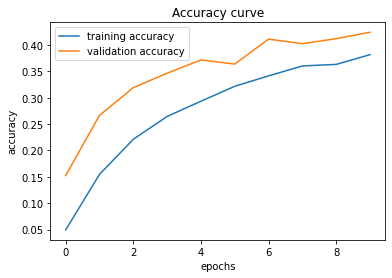

In [ ]:
history=history_class
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Accuracy curve')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

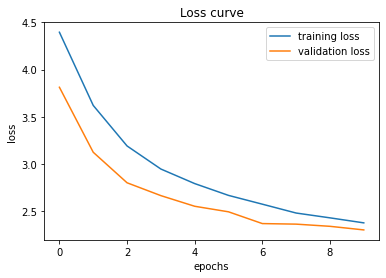

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [6]:
# Loading the model
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/gdrive/My Drive/Food Image Recognition/food_image_recognition.hdf5',compile=False)

In [7]:
# labels of 101 classes of food
food_list=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup', 'mussels', 'nachos', 'omelette', 'onion_rings', 'oysters', 'pad_thai', 'paella', 'pancakes', 'panna_cotta', 'peking_duck', 'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib', 'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto', 'samosa', 'sashimi', 'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese', 'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake', 'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles']
food_list.sort()

In [8]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)    
    img /= 255. 
    pred = loaded_model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]

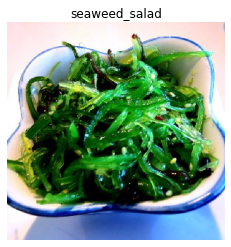

In [9]:
# Test
images = []
images.append('/content/gdrive/My Drive/Food Image Recognition/test.jpg')
predict_class(loaded_model, images, True)